### Importando Bibliotecas

In [ ]:
# Instalação dos pacotes que não vêm por padrão no SageMaker Studio
!pip install -q scikit-posthocs xgboost lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import math

pd.set_option('display.max_rows', None, 'display.max_columns', None)

### Integração e Pré-Processamento

In [2]:
# Carrega a base de dados ".csv"
df = pd.read_csv("microdados_2023_tratado.csv", sep=';', decimal=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259755 entries, 0 to 259754
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   situacao         259755 non-null  object 
 1   Cor / Raça       259755 non-null  object 
 2   eixo_tec         259755 non-null  object 
 3   faixa_etaria     259755 non-null  object 
 4   esforco          259755 non-null  float64
 5   financiamento    259755 non-null  object 
 6   modalidade       259755 non-null  object 
 7   curso            259755 non-null  object 
 8   renda_familiar   259755 non-null  object 
 9   Sexo             259755 non-null  object 
 10  subeixo_tec      254818 non-null  object 
 11  tipo_curso       259755 non-null  object 
 12  tipo_oferta      259755 non-null  object 
 13  turno            259755 non-null  object 
 14  uf               259755 non-null  object 
 15  unidade          259755 non-null  object 
 16  vagas_regulares  259755 non-null  floa

Contagem de cada classe:
situacao
Evadidos       117559
Concluintes     99497
Em Curso        42699
Name: count, dtype: int64

Percentual de cada classe:
situacao
Evadidos       45.257647
Concluintes    38.304171
Em Curso       16.438182
Name: proportion, dtype: float64


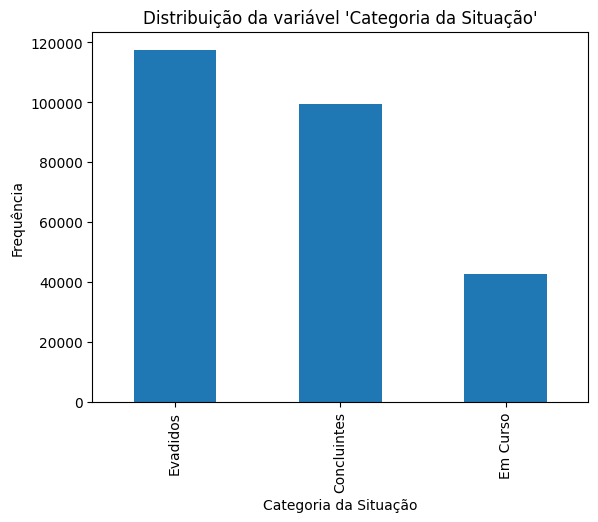

In [4]:
# Verifica a distribuição da variável de previsão
print("Contagem de cada classe:")
print(df['situacao'].value_counts())

print("\nPercentual de cada classe:")
print(df['situacao'].value_counts(normalize=True) * 100)

# plot para visualizar a distribuição
df['situacao'].value_counts().plot(kind='bar')
plt.title("Distribuição da variável 'Categoria da Situação'")
plt.xlabel("Categoria da Situação")
plt.ylabel("Frequência")
plt.show()

In [5]:
# Verifica a quantidade de dados ausentes em cada coluna
missing_data = df.isnull().sum()
print("Dados ausentes por coluna:")
print(missing_data)

# mostra o percentual de dados ausentes em cada coluna
percent_missing = (df.isnull().sum() / len(df)) * 100
print("\nPercentual de dados ausentes por coluna:")
print(percent_missing)



Dados ausentes por coluna:
situacao              0
Cor / Raça            0
eixo_tec              0
faixa_etaria          0
esforco               0
financiamento         0
modalidade            0
curso                 0
renda_familiar        0
Sexo                  0
subeixo_tec        4937
tipo_curso            0
tipo_oferta           0
turno                 0
uf                    0
unidade               0
vagas_regulares       0
duracao_curso         0
municipio           725
rap                 725
taxa_ocup          1494
servidores          725
itcd                725
hier_urbana         725
pib_percap          725
dtype: int64

Percentual de dados ausentes por coluna:
situacao           0.000000
Cor / Raça         0.000000
eixo_tec           0.000000
faixa_etaria       0.000000
esforco            0.000000
financiamento      0.000000
modalidade         0.000000
curso              0.000000
renda_familiar     0.000000
Sexo               0.000000
subeixo_tec        1.900637
tipo_curso

In [6]:
print(df.rap.isnull().sum())
print(df.rap.str.contains(",").sum())
print(df.rap.str.contains(".").sum())

725
0
259030


In [7]:
# Tratamento de dados ausentes
df['rap'] = df.rap[df['rap']!= "(Em branco)"]
df['rap'] = df.rap[df['rap']!= "()"]
df = df[df['rap'].notna()]
# Substitua strings vazias por NaN
df['rap'] = df['rap'].replace('', pd.NA)
# Converter para float
df['rap'] = df['rap'].astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255777 entries, 0 to 259754
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   situacao         255777 non-null  object 
 1   Cor / Raça       255777 non-null  object 
 2   eixo_tec         255777 non-null  object 
 3   faixa_etaria     255777 non-null  object 
 4   esforco          255777 non-null  float64
 5   financiamento    255777 non-null  object 
 6   modalidade       255777 non-null  object 
 7   curso            255777 non-null  object 
 8   renda_familiar   255777 non-null  object 
 9   Sexo             255777 non-null  object 
 10  subeixo_tec      250840 non-null  object 
 11  tipo_curso       255777 non-null  object 
 12  tipo_oferta      255777 non-null  object 
 13  turno            255777 non-null  object 
 14  uf               255777 non-null  object 
 15  unidade          255777 non-null  object 
 16  vagas_regulares  255777 non-null  float64
 

In [9]:
# Selecionar apenas as colunas do tipo 'object'
df_object = df.select_dtypes(include=['object'])

# Contar os itens únicos em cada coluna do DataFrame resultante
contagem_unicos_object = df_object.nunique()

# Imprimir o resultado
print(contagem_unicos_object)

situacao            3
Cor / Raça          6
eixo_tec           14
faixa_etaria       12
financiamento       6
modalidade          2
curso             320
renda_familiar      7
Sexo                3
subeixo_tec        46
tipo_curso         13
tipo_oferta         7
turno               5
uf                 27
unidade           627
municipio         555
hier_urbana         5
dtype: int64


In [10]:
#Mapas
map_situacao_matricula = {'Concluintes': 0, 'Em Curso': 0, 'Evadidos': 1}

map_faixa_etaria = {'Menor de 14 anos':1,'15 a 19 anos':2,'20 a 24 anos':3, '25 a 29 anos':4,
        '30 a 34 anos':5,'35 a 39 anos':6,'40 a 44 anos':7,'45 a 49 anos':8,
        '50 a 54 anos':9, 'Maior de 60 anos':10,'55 a 59 anos':11, 'S/I':0}


df['situacao'] = df['situacao'].map(map_situacao_matricula)
df['faixa_etaria'] = df['faixa_etaria'].map(map_faixa_etaria)


In [11]:
# LabelEncoder para as colunas do tipo objeto
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
objList = df.select_dtypes(include = "object").columns

for feat in objList:
    df[feat] = lb.fit_transform(df[feat].astype(str))

In [12]:
# Data pré-processado e pronto para análise

print("Dados após o pré-processamento:")
print(df.head())
print(df.info())

Dados após o pré-processamento:
   situacao  Cor / Raça  eixo_tec  faixa_etaria  esforco  financiamento  \
0         0           4         2             8    1.500              4   
1         1           1         1             6    1.078              4   
2         1           1         2             6    1.239              4   
3         0           4         5             6    1.032              4   
4         0           4         1             7    1.078              4   

   modalidade  curso  renda_familiar  Sexo  subeixo_tec  tipo_curso  \
0           0    172               0     1           13           0   
1           0     51               0     0           26           0   
2           0      8               5     0           11           8   
3           0     88               2     1            6          11   
4           0     51               6     1           26           0   

   tipo_oferta  turno  uf  unidade  vagas_regulares  duracao_curso  municipio  \
0        

## Treino

In [13]:
# Ferramentas de imputação e seleção de atributos
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest

# Modelos de classificação
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Encadeamento de transformações e estimadores
from sklearn.pipeline import Pipeline

# Validação e métricas
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc

# Testes estatísticos
from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp


In [14]:
# Separa as features (X) e o alvo (y)
X = df.drop('situacao', axis=1)
y = df['situacao']

In [15]:
# Define um seed para reprodutibilidade
seed = 42

# Define o scorer como acurácia (poderia usar F1, precision, recall...)
scorer = make_scorer(accuracy_score)     # acurácia
# scorer = make_scorer(precision_score)  # precisão (quantos dos positivos previstos são realmente positivos)
# scorer = make_scorer(recall_score)     #  sensibilidade (recall) (quantos dos positivos reais foram identificados)
# scorer = make_scorer(f1_score)         # equilíbrio entre precisão e recall (média harmônica entre os dois)


# Estratégia de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)   # Para avaliação final
gscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)  # Para grid search

# Dicionário de algoritmos e parâmetros (GridSearchCV)
jobs = -1  # usar todos os núcleos

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Assume 'scorer', 'gscv', 'jobs', and 'seed' are already defined

algorithms = {
    'kNN': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler(feature_range=(0, 1))),
            ('selector', VarianceThreshold()),
            ('knn', KNeighborsClassifier())
        ]),
        param_grid={
            'selector__threshold': [0, 0.01, 0.02, 0.03],
            'knn__n_neighbors': [1, 3, 5],
            'knn__p': [1, 2],
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    ),
    'tree': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('tree', DecisionTreeClassifier(random_state=seed))
        ]),
        param_grid={
            'tree__max_depth': [5, 10, 20],
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    ),
    'rf': GridSearchCV(  # Added Random Forest
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('rf', RandomForestClassifier(random_state=seed))
        ]),
        param_grid={
            'rf__n_estimators': [50, 100, 200],
            'rf__max_depth': [None, 10, 20],
            'rf__min_samples_split': [2, 5, 10],
            'rf__min_samples_leaf': [1, 3, 5],
            'rf__criterion': ['gini', 'entropy']
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    ),
        'SGBoost': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('sgb', HistGradientBoostingClassifier(random_state=seed))
        ]),
        param_grid={
            'sgb__max_iter': [100, 200],
            'sgb__learning_rate': [0.1, 0.01],
            'sgb__max_depth': [None, 10]
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    ),
    'LightGBM': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('lgbm', LGBMClassifier(objective='multiclass', num_class=24, random_state=seed))
        ]),
        param_grid={
            'lgbm__n_estimators': [100, 200],
            'lgbm__learning_rate': [0.1, 0.01],
            'lgbm__max_depth': [10, 20]
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    ),
    'MLP': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler()),
            ('mlp', MLPClassifier(random_state=seed, max_iter=200))
        ]),
        param_grid={
            'mlp__hidden_layer_sizes': [(100,), (50, 50)],
            'mlp__activation': ['relu', 'tanh'],
            'mlp__alpha': [0.0001, 0.001]
        },
        scoring=scorer,
        cv=gscv,
        n_jobs=jobs
    )
}

# Treinamento (Validação Cruzada)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y, random_state=seed)

result = {}
for alg, clf in algorithms.items():
    print(f"\nTreinando e avaliando: {alg}")
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scorer, n_jobs=jobs)
    result[alg] = scores
    print(f"Acurácias (cross-val): {scores}")
    print(f"Média: {scores.mean():.4f} | Desvio: {scores.std():.4f}")


Treinando e avaliando: kNN
Acurácias (cross-val): [0.67808273 0.67597154 0.67902103 0.68465087 0.67628431 0.67550238
 0.67604973 0.67784815 0.67727557 0.67774476]
Média: 0.6778 | Desvio: 0.0025

Treinando e avaliando: tree
Acurácias (cross-val): [0.66963797 0.66291344 0.65978575 0.66901243 0.66025491 0.66338259
 0.66572836 0.66400813 0.67250547 0.66265249]
Média: 0.6650 | Desvio: 0.0040

Treinando e avaliando: rf


c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\lucas\AppData\

Acurácias (cross-val): [0.70803034        nan 0.7044335  0.70967237 0.70013293 0.70646649
        nan 0.70498084 0.71160463 0.70120425]
Média: nan | Desvio: nan

Treinando e avaliando: SGBoost
Acurácias (cross-val): [0.69778716 0.69567597 0.69802174 0.70388615 0.69067167 0.69974197
 0.69770897 0.69778716 0.703863   0.69823272]
Média: 0.6983 | Desvio: 0.0036

Treinando e avaliando: LightGBM
Acurácias (cross-val): [0.70200954 0.69974197 0.70052389 0.70967237 0.69551959 0.70294785
 0.70326061 0.70177496 0.70996246 0.70050047]
Média: 0.7026 | Desvio: 0.0042

Treinando e avaliando: MLP
Acurácias (cross-val): [0.67565877 0.67112362 0.67167097 0.67346939 0.67096724 0.67870826
 0.67088905 0.6723747  0.67227088 0.67078511]
Média: 0.6728 | Desvio: 0.0024


In [18]:
# Converte para DataFrame
result_df = pd.DataFrame.from_dict(result)
print("\nResultados de cross_val_score:")
print(result_df)


Resultados de cross_val_score:
        kNN      tree        rf   SGBoost  LightGBM       MLP
0  0.678083  0.669638  0.708030  0.697787  0.702010  0.675659
1  0.675972  0.662913       NaN  0.695676  0.699742  0.671124
2  0.679021  0.659786  0.704433  0.698022  0.700524  0.671671
3  0.684651  0.669012  0.709672  0.703886  0.709672  0.673469
4  0.676284  0.660255  0.700133  0.690672  0.695520  0.670967
5  0.675502  0.663383  0.706466  0.699742  0.702948  0.678708
6  0.676050  0.665728       NaN  0.697709  0.703261  0.670889
7  0.677848  0.664008  0.704981  0.697787  0.701775  0.672375
8  0.677276  0.672505  0.711605  0.703863  0.709962  0.672271
9  0.677745  0.662652  0.701204  0.698233  0.700500  0.670785


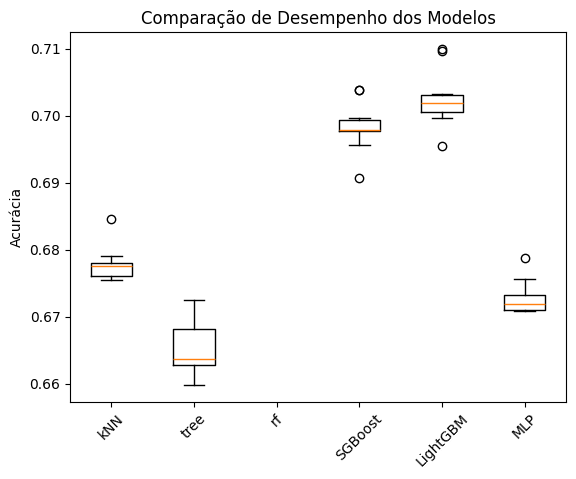

In [19]:
# Boxplot dos resultados
plt.boxplot([scores for alg, scores in result_df.items()])
plt.xticks(np.arange(1, result_df.shape[1] + 1), result_df.columns, rotation=45)
plt.ylabel("Acurácia")
plt.title("Comparação de Desempenho dos Modelos")
plt.show()

In [20]:
# Mostra média ± desvio
formatted_results = result_df.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))
print("\nResultados (acurácia) com média ± desvio:")
print(formatted_results)


Resultados (acurácia) com média ± desvio:
kNN         0.68 ± 0.00
tree        0.66 ± 0.00
rf          0.71 ± 0.00
SGBoost     0.70 ± 0.00
LightGBM    0.70 ± 0.00
MLP         0.67 ± 0.00
dtype: object


# Curva ROC para cada modelo


Modelo: kNN
Melhor score médio na validação cruzada: 0.6736
Melhores hiperparâmetros encontrados: {'knn__n_neighbors': 5, 'knn__p': 1, 'selector__threshold': 0}

Modelo: tree
Melhor score médio na validação cruzada: 0.6640
Melhores hiperparâmetros encontrados: {'tree__criterion': 'gini', 'tree__max_depth': 10}

Modelo: rf
Melhor score médio na validação cruzada: 0.7028
Melhores hiperparâmetros encontrados: {'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Modelo: SGBoost
Melhor score médio na validação cruzada: 0.6969
Melhores hiperparâmetros encontrados: {'sgb__learning_rate': 0.1, 'sgb__max_depth': None, 'sgb__max_iter': 200}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Num

c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_


Modelo: MLP
Melhor score médio na validação cruzada: 0.6687
Melhores hiperparâmetros encontrados: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50)}


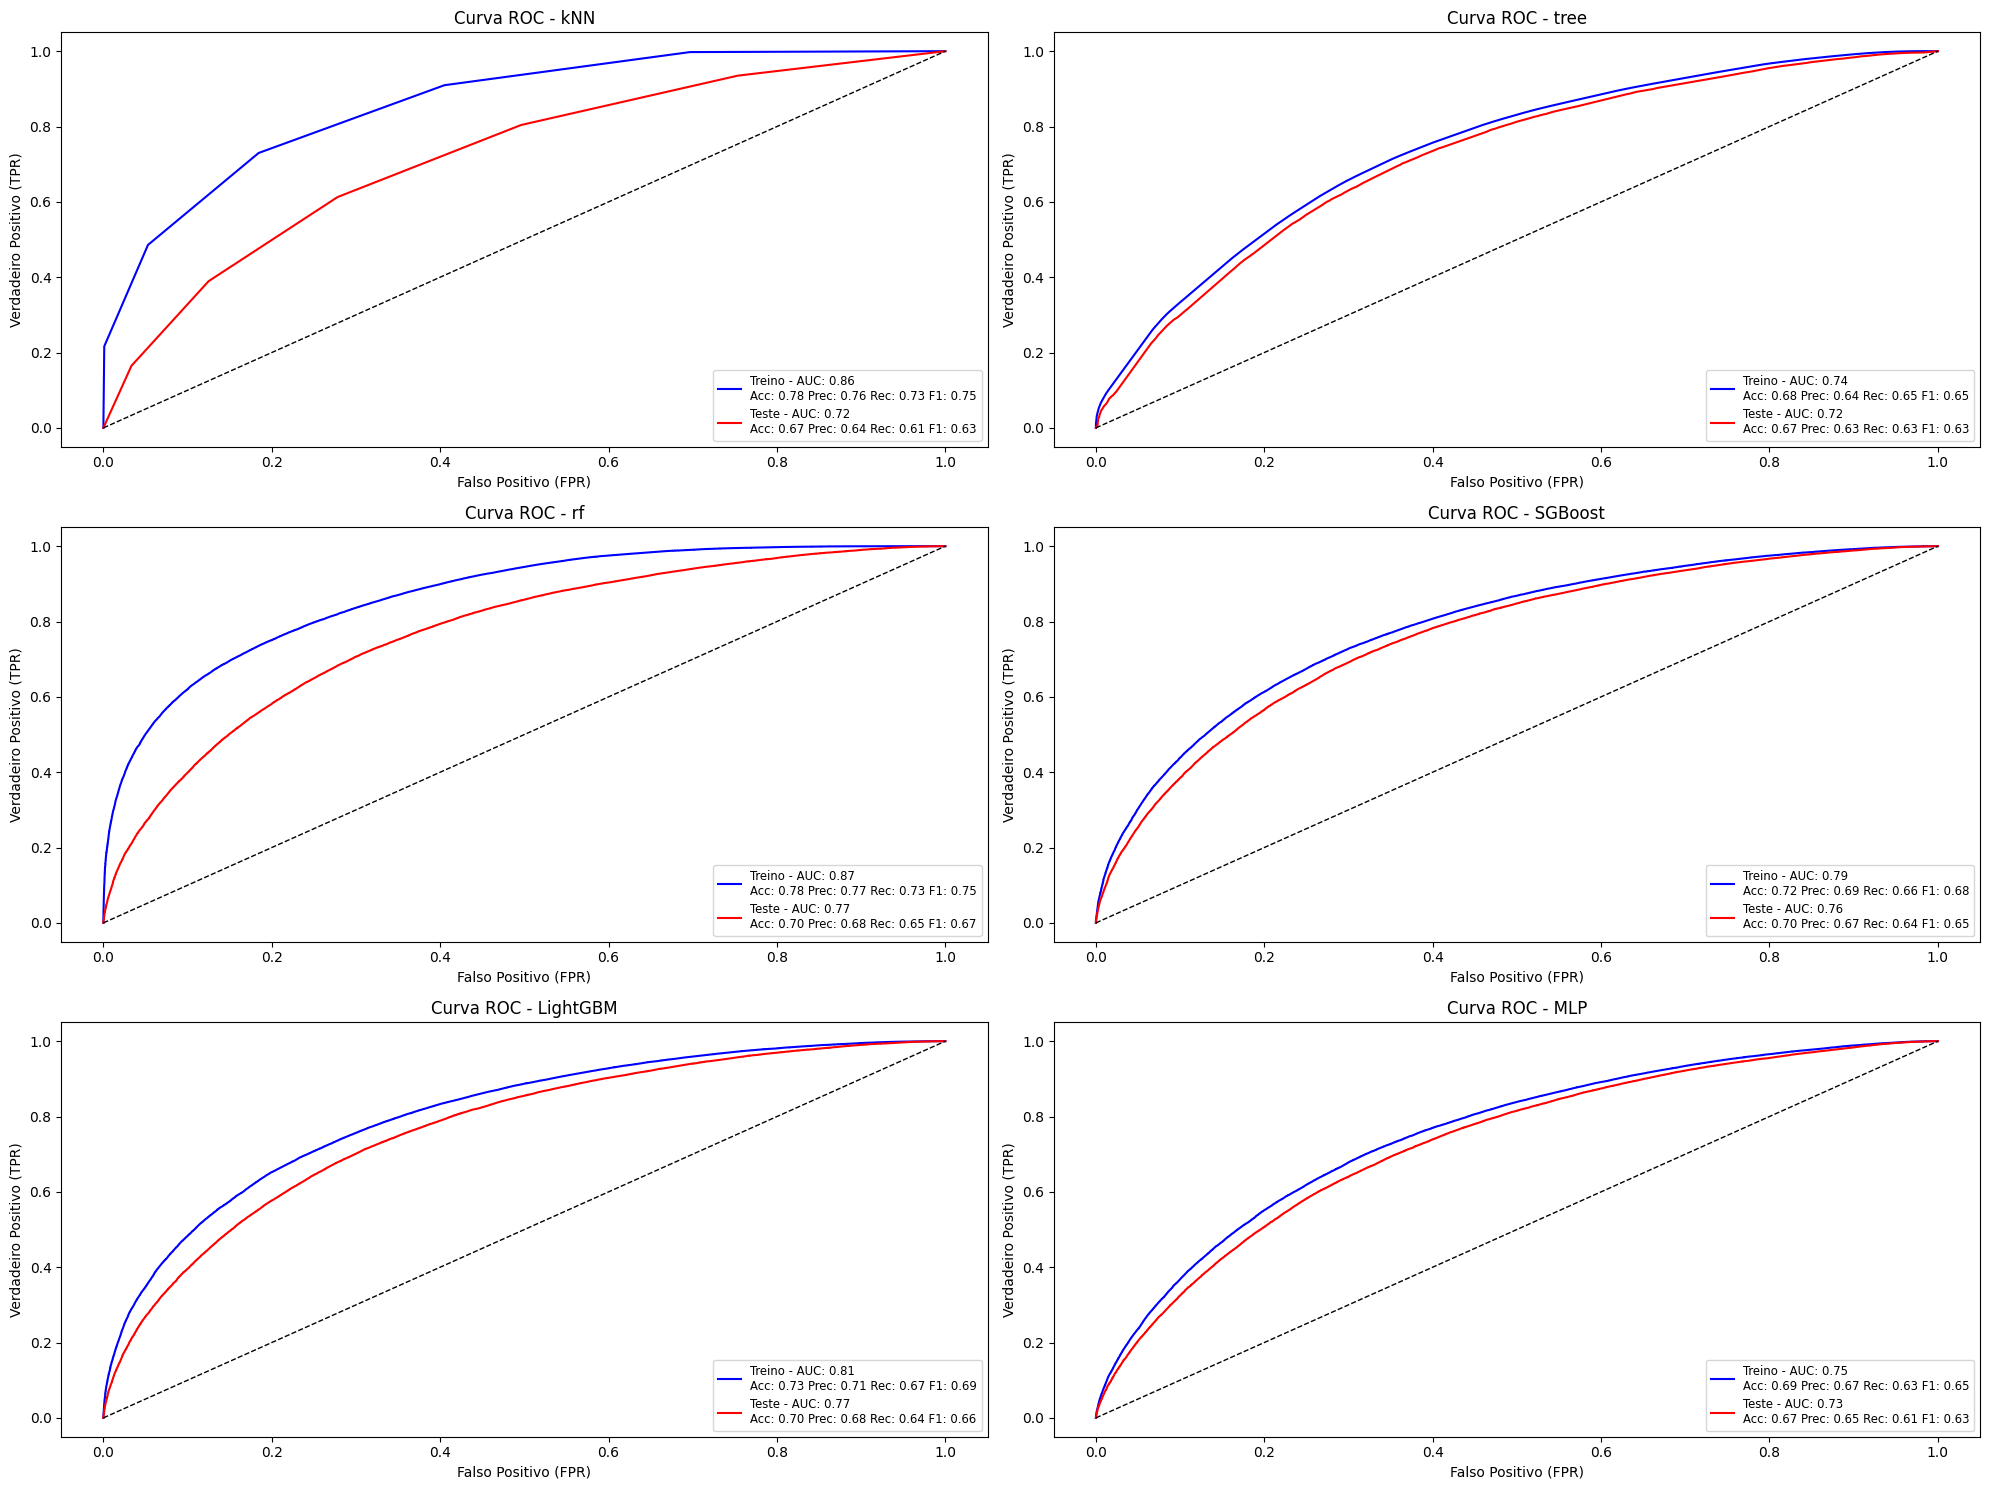

In [21]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import math

# Layout dos subplots: 2 gráficos por linha
n_alg = len(algorithms)
cols = 2
rows = math.ceil(n_alg / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10 * cols, 5 * rows))
axes = axes.flatten()

melhores_modelos = {}
resultados = []

for idx, (alg_name, grid) in enumerate(algorithms.items()):
    # Assume que grid já foi treinado
    grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    melhores_modelos[alg_name] = best_clf

    # Extrai e exibe os melhores hiperparâmetros e score de validação cruzada
    melhor_score = grid.best_score_
    melhores_parametros = grid.best_params_
    print(f"\nModelo: {alg_name}")
    print(f"Melhor score médio na validação cruzada: {melhor_score:.4f}")
    print(f"Melhores hiperparâmetros encontrados: {melhores_parametros}")

    ax = axes[idx]

    for split_type, X_split, y_split, color in [("Treino", X_train, y_train, "blue"), ("Teste", X_test, y_test, "red")]:
        if hasattr(best_clf, "predict_proba"):
            y_scores = best_clf.predict_proba(X_split)[:, 1]
        elif hasattr(best_clf, "decision_function"):
            y_scores = best_clf.decision_function(X_split)
        else:
            print(f"{alg_name} não suporta predição de probabilidades.")
            continue

        fpr, tpr, _ = roc_curve(y_split, y_scores)
        roc_auc = auc(fpr, tpr)

        y_pred = best_clf.predict(X_split)
        acc = accuracy_score(y_split, y_pred)
        prec = precision_score(y_split, y_pred)
        rec = recall_score(y_split, y_pred)
        f1 = f1_score(y_split, y_pred)

        ax.plot(fpr, tpr, color=color, label=(
            f"{split_type} - AUC: {roc_auc:.2f}\n"
            f"Acc: {acc:.2f} Prec: {prec:.2f} Rec: {rec:.2f} F1: {f1:.2f}"))

        resultados.append({
            "Modelo": alg_name,
            "Tipo": split_type,
            "AUC": roc_auc,
            "Acurácia": acc,
            "Precisão": prec,
            "Recall": rec,
            "F1-score": f1,
            "Score Validação Cruzada": melhor_score,
            "Hiperparâmetros": str(melhores_parametros)
        })


    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_title(f"Curva ROC - {alg_name}")
    ax.set_xlabel("Falso Positivo (FPR)")
    ax.set_ylabel("Verdadeiro Positivo (TPR)")
    ax.legend(loc="lower right", fontsize="small")

# Remove subplots extras (se houver)
for i in range(len(algorithms), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()




In [22]:
resultados

[{'Modelo': 'kNN',
  'Tipo': 'Treino',
  'AUC': np.float64(0.860145893384108),
  'Acurácia': 0.7770627423995996,
  'Precisão': 0.7632849361485071,
  'Recall': 0.7297443221401699,
  'F1-score': 0.7461378874355573,
  'Score Validação Cruzada': np.float64(0.6736128672897936),
  'Hiperparâmetros': "{'knn__n_neighbors': 5, 'knn__p': 1, 'selector__threshold': 0}"},
 {'Modelo': 'kNN',
  'Tipo': 'Teste',
  'AUC': np.float64(0.7215970402702221),
  'Acurácia': 0.6728725691810867,
  'Precisão': 0.6421896104844304,
  'Recall': 0.6127734429427337,
  'F1-score': 0.6271367711805493,
  'Score Validação Cruzada': np.float64(0.6736128672897936),
  'Hiperparâmetros': "{'knn__n_neighbors': 5, 'knn__p': 1, 'selector__threshold': 0}"},
 {'Modelo': 'tree',
  'Tipo': 'Treino',
  'AUC': np.float64(0.7421110544599425),
  'Acurácia': 0.6813383585637433,
  'Precisão': 0.6442059714409346,
  'Recall': 0.6482339417583949,
  'F1-score': 0.6462136798881857,
  'Score Validação Cruzada': np.float64(0.6640419729635344),
